In [201]:
import sys
from pathlib import Path
import json
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from pypalettes import load_cmap
import numpy as np
import importlib
import src.config


project_root = Path().resolve().parent 
sys.path.append(str(project_root))

from src.config import ANNOTATIONS_DIR, FIGURES_DIR

In [143]:
train_instances_path = ANNOTATIONS_DIR / "instances_attributes_train2020.json"
val_instances_path = ANNOTATIONS_DIR / "instances_attributes_val2020.json"
train_attributes_path = ANNOTATIONS_DIR / "attributes_train2020.json"
val_attributes_path = ANNOTATIONS_DIR / "attributes_val2020.json"
test_info_path = ANNOTATIONS_DIR / "info_test2020.json"


with open(train_instances_path, "r") as file:
    train_instances = json.load(file)

with open(val_instances_path, "r") as file:
    val_instances = json.load(file)

with open(train_attributes_path, "r") as file:
    train_attributes = json.load(file)

with open(val_attributes_path, "r") as file:
    val_attributes = json.load(file)

with open(test_info_path, "r") as file:
    test_info = json.load(file)

In [145]:
category_mapping = {
    category["id"]: category["name"] for category in test_info["categories"]
}

def get_instance_df(instances, attributes, ds):
    annotations = instances["annotations"]

    data = []
    for annotation in annotations:
        image_id = annotation["image_id"]
        category_id = annotation["category_id"]
        category_name = category_mapping.get(category_id)
        bbox = annotation["bbox"]
        area = annotation["area"]
        image = next(
            (img for img in attributes["images"] if img["id"] == image_id), None
        )
        total_area = image["width"] * image["height"]

        data.append((image_id, category_id, category_name, bbox, area, total_area, ds))

    return pd.DataFrame(
        data,
        columns=[
            "image_id",
            "category_id",
            "category_name",
            "bbox",
            "area",
            "total_area",
            "dataset",  
        ],
    )


train_instance_df = get_instance_df(train_instances, train_attributes, "train")
val_instance_df = get_instance_df(val_instances, val_attributes, "val")

instance_df = pd.concat([train_instance_df, val_instance_df])

instance_df


,image_id,category_id,category_name,bbox,area,total_area,dataset
0,16305,32,pocket,"[454.0, 390.0, 46.0, 109.0]",3052,696320,train
1,16305,31,sleeve,"[271.0, 133.0, 98.0, 223.0]",12906,696320,train
2,16305,31,sleeve,"[482.0, 323.0, 74.0, 169.0]",5794,696320,train
3,16305,22,sock,"[322.0, 658.0, 208.0, 112.0]",3838,696320,train
4,16305,22,sock,"[405.0, 749.0, 97.0, 213.0]",9415,696320,train
...,...,...,...,...,...,...,...
8776,13599,8,skirt,"[439.0, 406.0, 233.0, 523.0]",62602,925696,val
8777,13599,23,shoe,"[616.0, 901.0, 50.0, 80.0]",1531,925696,val
8778,13599,23,shoe,"[596.0, 880.0, 15.0, 37.0]",248,925696,val
8779,13599,31,sleeve,"[561.0, 202.0, 109.0, 304.0]",10809,925696,val


## Counting the number of images per label

In [132]:
image_count_df = (
    instance_df.groupby(["category_id", "category_name"])["image_id"]
    .nunique() 
    .reset_index(name="image_count")  
)

label_count_df = (
    instance_df.groupby(["category_id", "category_name"])["category_id"]
    .count() 
    .reset_index(name="label_count")  
)

count_df = image_count_df.merge(
    label_count_df, on=["category_id", "category_name"]
)

assert count_df["label_count"].sum() == len(train_instances["annotations"]) + len(
    val_instances["annotations"]
)

count_df

,category_id,category_name,image_count,label_count
0,0,"shirt, blouse",6217,6263
1,1,"top, t-shirt, sweatshirt",16639,17025
2,2,sweater,1506,1515
3,3,cardigan,1113,1119
4,4,jacket,7921,8016
5,5,vest,738,741
6,6,pants,12660,12728
7,7,shorts,2851,2862
8,8,skirt,5196,5208
9,9,coat,3188,3228


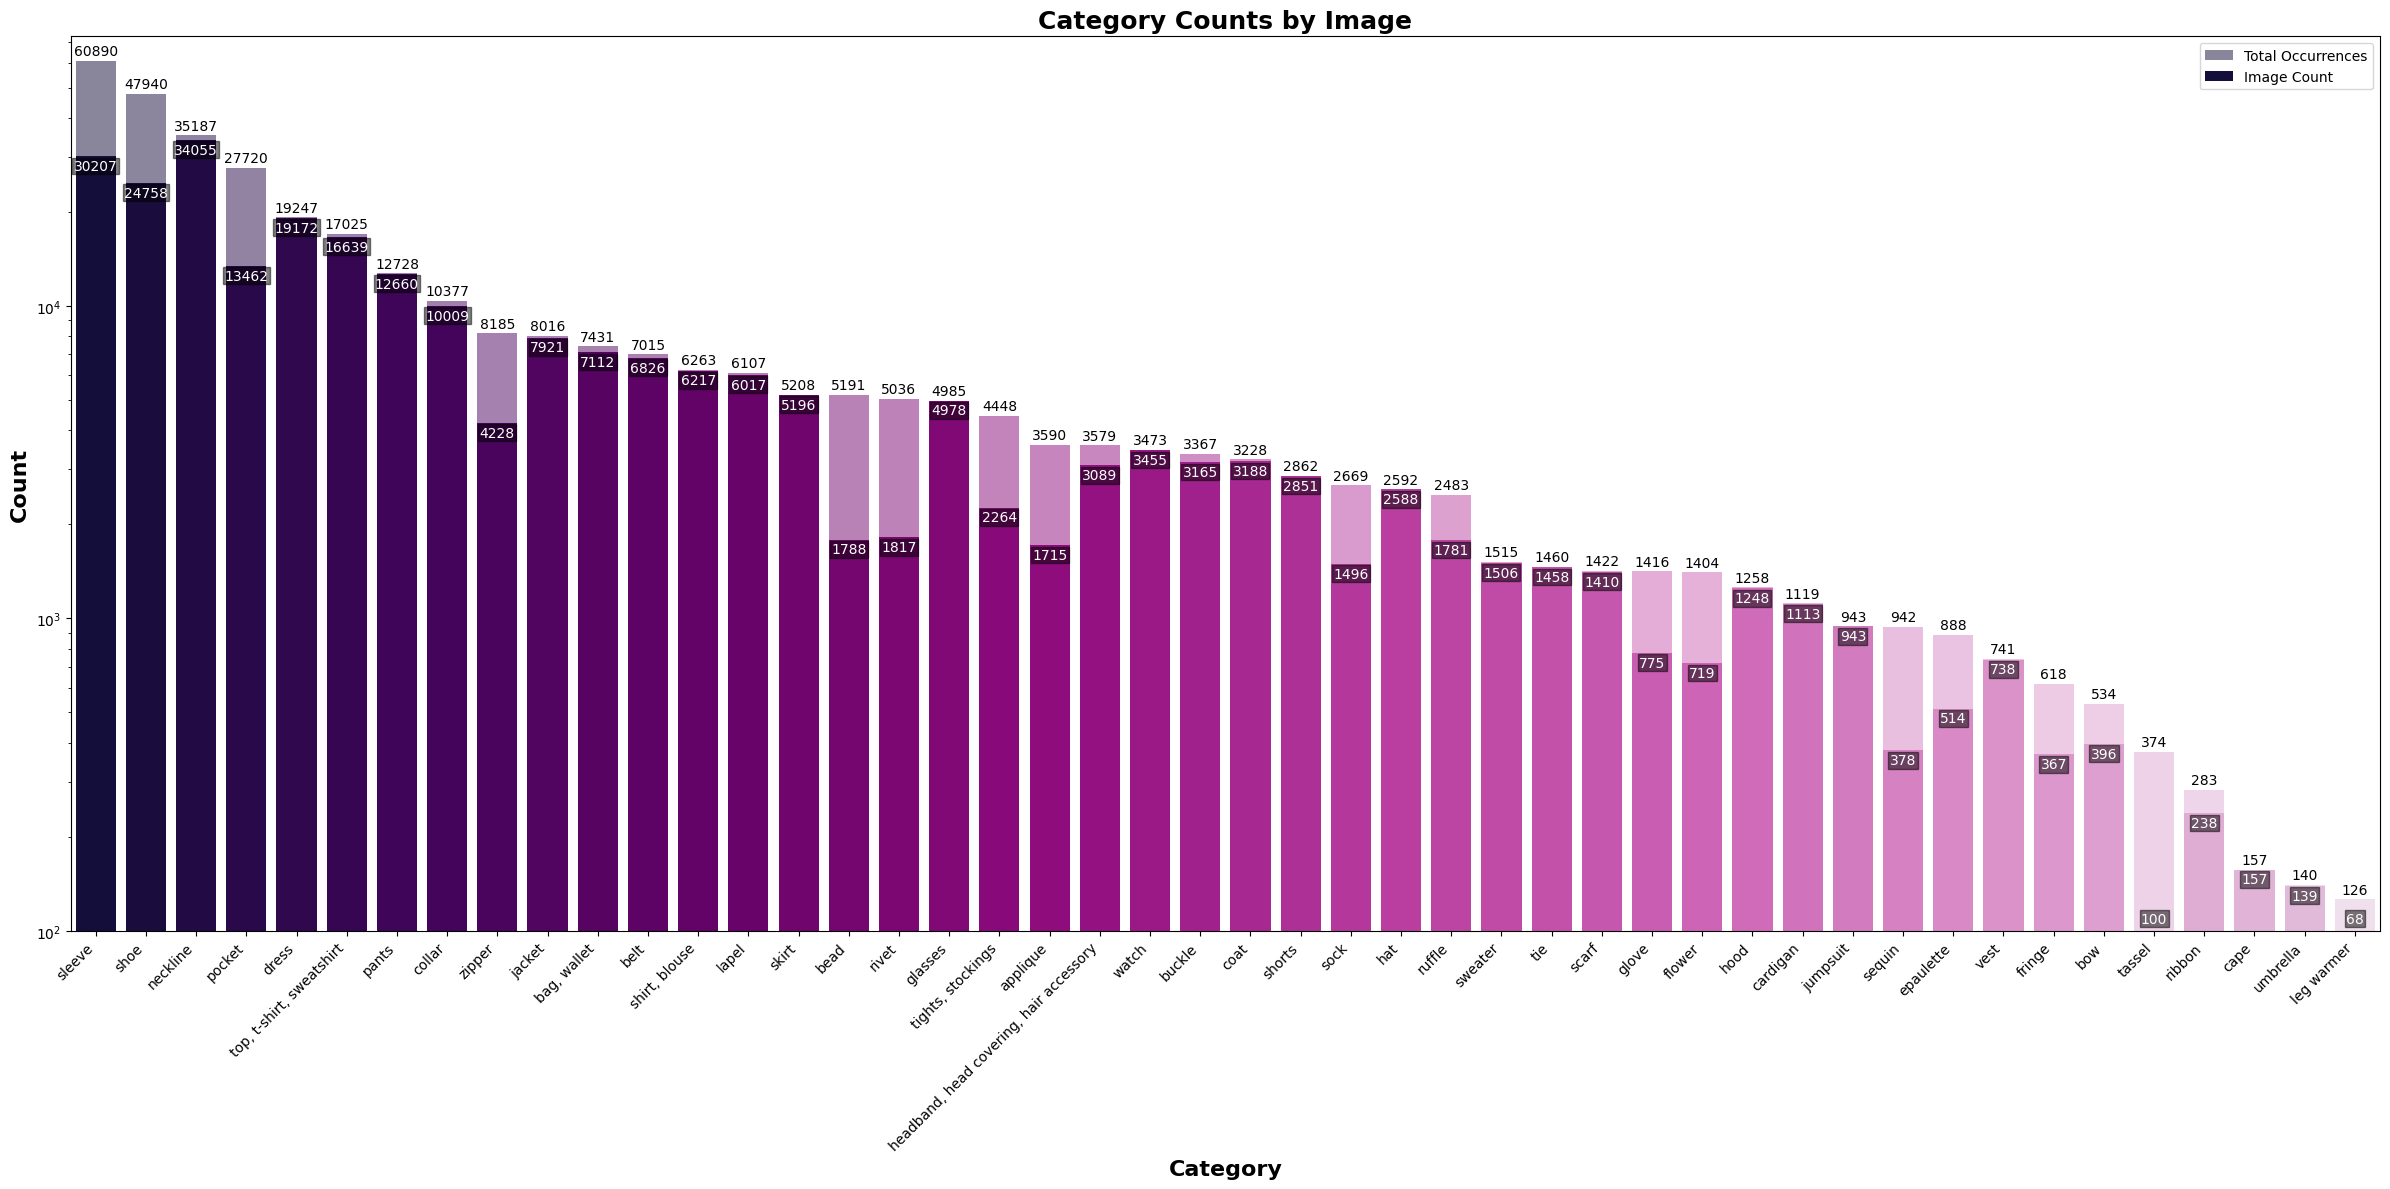

In [133]:
cmap = load_cmap("Flash", cmap_type="continuous", reverse=True)

num_categories = len(count_df)

color_values = np.linspace(0, 1, num_categories)

colors = [cmap(value) for value in color_values]

sorted_stats = count_df.sort_values("label_count", ascending=False)

plt.figure(figsize=(24, 12))  

plt.ylim(100, sorted_stats["label_count"].max() * 1.2)

bars1 = plt.bar(
    range(len(sorted_stats)),
    sorted_stats["label_count"],
    alpha=0.5,
    color=colors,
    label="Total Occurrences",
)

bars2 = plt.bar(
    range(len(sorted_stats)),
    sorted_stats["image_count"],
    color=colors,
    label="Image Count",
)

plt.xticks(
    range(len(sorted_stats)), sorted_stats["category_name"], rotation=45, ha="right"
)

plt.xlabel("Category", fontsize=16, fontweight="bold")
plt.ylabel("Count", fontsize=16, fontweight="bold")
plt.title("Category Counts by Image", fontsize=18, fontweight="bold")

plt.yscale("log")
plt.xlim(-0.5, len(sorted_stats) - 0.5)

# Add count labels on top of bars
for bar in bars1:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height * 1.02,  # Slightly above the bar
        f"{int(height)}",
        ha="center",
        va="bottom",
    )

for bar in bars2:
    height = bar.get_height()
    label_y_position = max(height * 0.98, 115)  # Ensure labels don't drop below 115

    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        label_y_position,
        f"{int(height)}",
        ha="center",
        va="top",
        color="white",
        bbox=dict(facecolor="black", alpha=0.5, pad=1),
    )

plt.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / "category_counts_by_image.png")
plt.show()


## Mean and Variance for the Pixel Ratio per Category

In [211]:
from shapely.geometry import box
from shapely.ops import unary_union


def compute_non_foreground_area(df):
    """
    Compute the total non-foreground area for each image_id
    considering overlapping bounding boxes only once.
    """
    non_foreground_areas = {}

    for image_id, group in df.groupby("image_id"):
        bboxes = [box(*bbox) for bbox in group["bbox"]]  # Convert to shapely polygons
        union_area = unary_union(
            bboxes
        ).area  # Compute the union area (avoids double subtraction)
        non_foreground_areas[image_id] = union_area

    return non_foreground_areas


# Create a copy of relevant columns
area_df = instance_df[
    ["image_id", "category_id", "category_name", "bbox", "area", "total_area"]
].copy()

# Compute the non-foreground area using bounding box unions
non_foreground_area_dict = compute_non_foreground_area(area_df)

# Assign foreground area: total area - non_foreground area
area_df["foreground_area"] = area_df["image_id"].map(
    lambda x: area_df.loc[area_df["image_id"] == x, "total_area"].values[0]
    - non_foreground_area_dict[x]
)

# Ensure non-negative values
area_df["foreground_area"] = np.maximum(0, area_df["foreground_area"])

# Compute area ratios
area_df["area_ratio"] = area_df["area"] / area_df["total_area"]
area_df["foreground_area_ratio"] = np.minimum(1, area_df["area"] / area_df["foreground_area"])

area_df


,image_id,category_id,category_name,bbox,area,total_area,foreground_area,area_ratio,foreground_area_ratio
0,16305,32,pocket,"[454.0, 390.0, 46.0, 109.0]",3052,696320,457136.0,0.004383,0.006676
1,16305,31,sleeve,"[271.0, 133.0, 98.0, 223.0]",12906,696320,457136.0,0.018535,0.028232
2,16305,31,sleeve,"[482.0, 323.0, 74.0, 169.0]",5794,696320,457136.0,0.008321,0.012675
3,16305,22,sock,"[322.0, 658.0, 208.0, 112.0]",3838,696320,457136.0,0.005512,0.008396
4,16305,22,sock,"[405.0, 749.0, 97.0, 213.0]",9415,696320,457136.0,0.013521,0.020596
...,...,...,...,...,...,...,...,...,...
8776,13599,8,skirt,"[439.0, 406.0, 233.0, 523.0]",62602,925696,408027.0,0.067627,0.153426
8777,13599,23,shoe,"[616.0, 901.0, 50.0, 80.0]",1531,925696,408027.0,0.001654,0.003752
8778,13599,23,shoe,"[596.0, 880.0, 15.0, 37.0]",248,925696,408027.0,0.000268,0.000608
8779,13599,31,sleeve,"[561.0, 202.0, 109.0, 304.0]",10809,925696,408027.0,0.011677,0.026491


In [213]:
mean_stdev_area_df = (
    area_df.groupby(["category_id", "category_name"])
    .agg(
        area_ratio_mean=("area_ratio", "mean"),
        area_ratio_median=("area_ratio", "median"),
        area_ratio_stdev=("area_ratio", "std"),
        foreground_area_ratio_mean=("foreground_area_ratio", "mean"),
        foreground_area_ratio_median=("foreground_area_ratio", "median"),
        foreground_area_ratio_stdev=("foreground_area_ratio", "std"),
    )
    .reset_index()
)

mean_stdev_area_df

,category_id,category_name,area_ratio_mean,area_ratio_median,area_ratio_stdev,foreground_area_ratio_mean,foreground_area_ratio_median,foreground_area_ratio_stdev
0,0,"shirt, blouse",0.093120,0.035904,0.140768,0.158371,0.061118,0.239473
1,1,"top, t-shirt, sweatshirt",0.106995,0.044971,0.149426,0.176800,0.072056,0.254556
2,2,sweater,0.217322,0.128102,0.207131,0.355271,0.209823,0.332682
3,3,cardigan,0.164625,0.074916,0.198394,0.260583,0.119546,0.300456
4,4,jacket,0.133398,0.083535,0.132275,0.234602,0.138622,0.246310
5,5,vest,0.068112,0.037086,0.097492,0.115492,0.059406,0.171092
6,6,pants,0.070919,0.060063,0.068444,0.119569,0.100175,0.109526
7,7,shorts,0.049529,0.024489,0.094227,0.079360,0.041187,0.148888
8,8,skirt,0.086866,0.060649,0.095309,0.130766,0.093993,0.137455
9,9,coat,0.162989,0.113517,0.144889,0.275778,0.185197,0.251111


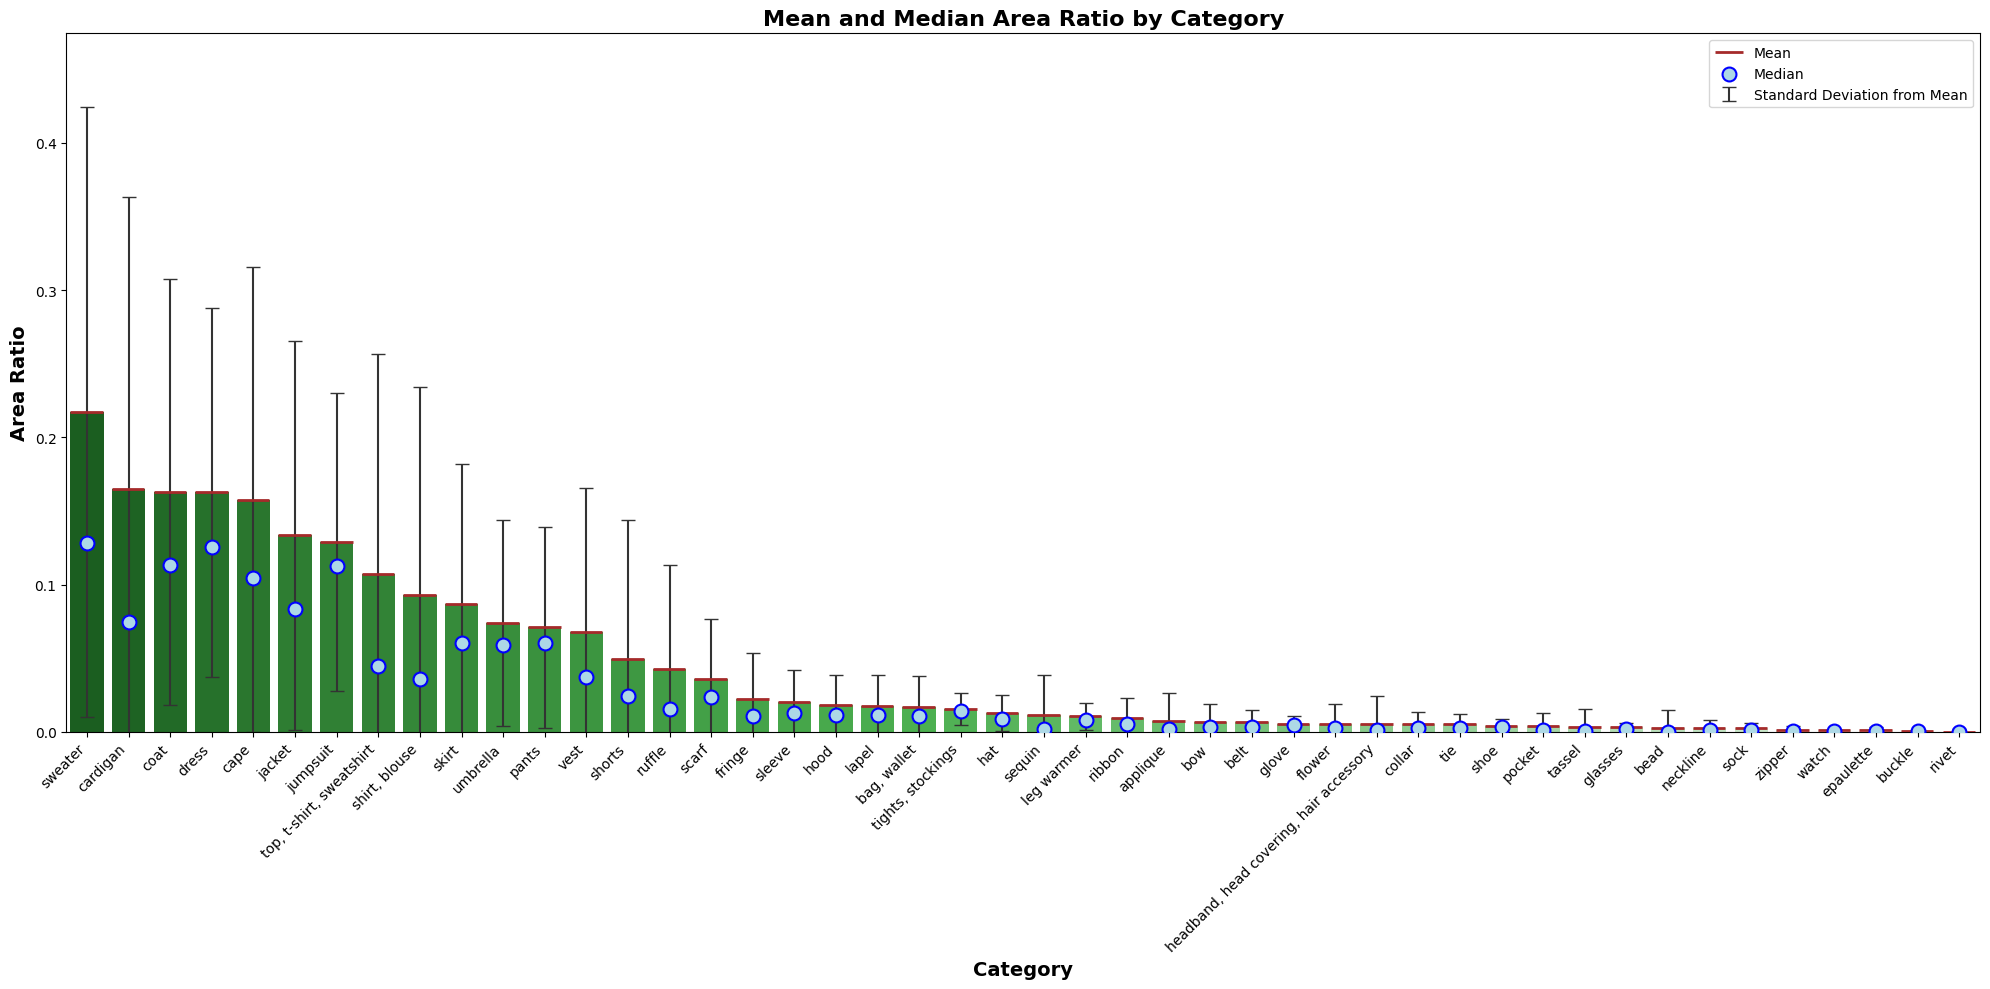

In [214]:
sorted_stats = mean_stdev_area_df.sort_values("area_ratio_mean", ascending=False)

cmap = load_cmap("green_material", cmap_type="continuous", reverse=True)

num_categories = len(sorted_stats)

color_values = np.linspace(0, 1, num_categories)

colors = [cmap(value) for value in color_values]

plt.figure(figsize=(20, 10))

bar_width = 0.8  
x_positions = np.arange(len(sorted_stats))

plt.bar(x_positions, sorted_stats["area_ratio_mean"], color=colors, width=bar_width)

plt.errorbar(
    x_positions,
    sorted_stats["area_ratio_mean"],
    yerr=sorted_stats["area_ratio_stdev"],
    ecolor="#333333",
    capsize=5,
    fmt="none",
    label="Standard Deviation from Mean",
)

plt.hlines(
    y=sorted_stats["area_ratio_mean"],
    xmin=x_positions - 0.4,
    xmax=x_positions + 0.38,
    colors="brown",
    linewidth=2,
    label="Mean",
    zorder=3,
)

plt.xticks(x_positions, sorted_stats["category_name"], rotation=45, ha="right")

plt.xlim(-0.5, len(sorted_stats) - 0.5) 

plt.xlabel("Category", fontsize=14, fontweight="bold")
plt.ylabel("Area Ratio", fontsize=14, fontweight="bold")
plt.title("Mean and Median Area Ratio by Category", fontsize=16, fontweight="bold")

plt.scatter(
    x_positions,
    sorted_stats["area_ratio_median"],
    marker="o",
    color="lightblue",
    edgecolor="blue",
    linewidth=1.5,
    s=100,
    zorder=4,
    label="Median",
)

upper_limit = (
    sorted_stats["area_ratio_mean"] + sorted_stats["area_ratio_stdev"]
).max() + 0.05
plt.ylim(0, upper_limit)

plt.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / "category_area_ratio.png")
plt.show()

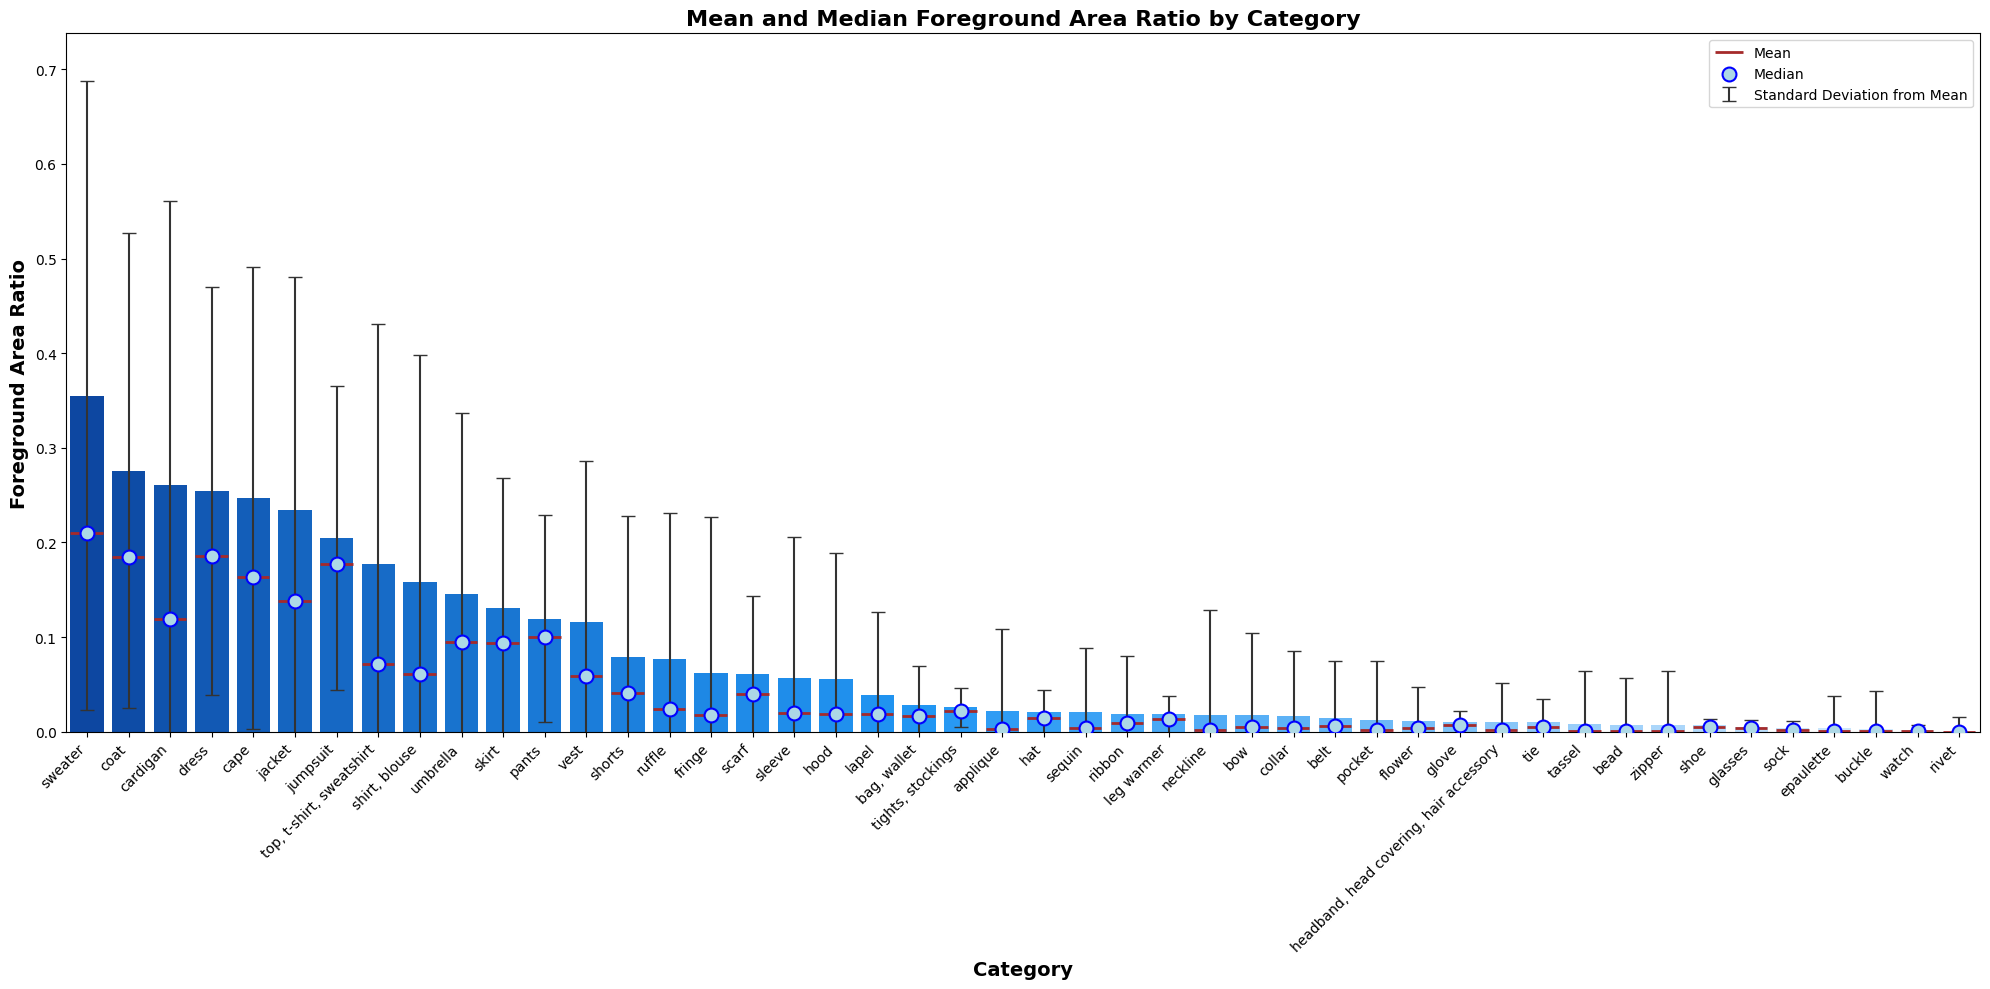

In [215]:
sorted_stats = mean_stdev_area_df.sort_values(
    "foreground_area_ratio_mean", ascending=False
)

cmap = load_cmap("blue_material", cmap_type="continuous", reverse=True)

num_categories = len(sorted_stats)

color_values = np.linspace(0, 1, num_categories)

colors = [cmap(value) for value in color_values]

plt.figure(figsize=(20, 10))

bar_width = 0.8
x_positions = np.arange(len(sorted_stats))

plt.bar(x_positions, sorted_stats["foreground_area_ratio_mean"], color=colors, width=bar_width)

plt.errorbar(
    x_positions,
    sorted_stats["foreground_area_ratio_mean"],
    yerr=sorted_stats["foreground_area_ratio_stdev"],
    ecolor="#333333",
    capsize=5,
    fmt="none",
    label="Standard Deviation from Mean",
)

plt.hlines(
    y=sorted_stats["foreground_area_ratio_median"],
    xmin=x_positions - 0.4,
    xmax=x_positions + 0.38,
    colors="brown",
    linewidth=2,
    label="Mean",
    zorder=3,
)

plt.xticks(x_positions, sorted_stats["category_name"], rotation=45, ha="right")

plt.xlim(-0.5, len(sorted_stats) - 0.5)

plt.xlabel("Category", fontsize=14, fontweight="bold")
plt.ylabel("Foreground Area Ratio", fontsize=14, fontweight="bold")
plt.title("Mean and Median Foreground Area Ratio by Category", fontsize=16, fontweight="bold")

plt.scatter(
    x_positions,
    sorted_stats["foreground_area_ratio_median"],
    marker="o",
    color="lightblue",
    edgecolor="blue",
    linewidth=1.5,
    s=100,
    zorder=4,
    label="Median",
)

upper_limit = (
    sorted_stats["foreground_area_ratio_mean"]
    + sorted_stats["foreground_area_ratio_stdev"]
).max() + 0.05
plt.ylim(0, upper_limit)

plt.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / "category_foreground_area_ratio.png")
plt.show()